# Team Members:

1) Sagar Panwar
2) Noopur Pramod Waghulde
3) Zhiqiang Yu

# Imports

In [1]:
# Basic Import
import warnings
import gc
import os
import cv2
from tqdm import tqdm
import pandas as pd
import kagglehub
import numpy as np
import PIL
from PIL import Image
import random
from collections import defaultdict

# torch
import torch, torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore Warning
warnings.filterwarnings("ignore")

# Paths
**Storing File Paths**: Below we are storing the file paths so that it can be used for loading the data.

In [2]:
image_path = '/kaggle/input/polytech-nice-deep-learning-course-2024/Images'
cat_path = '/kaggle/input/polytech-nice-deep-learning-course-2024/categories_ids.csv'
label_path = '/kaggle/input/polytech-nice-deep-learning-course-2024/polytech_trainval_labels.csv'
sample_submission_path = '/kaggle/input/polytech-nice-deep-learning-course-2024/sample_submission.csv'

# Section 1: Exploratory Data Analysis
**Data Loading**: We load the different input data (categorical, image , and train-validation data) and available to us in a Pandas dataframe and understand its dimensions and content.

In [3]:
df_cat = pd.read_csv(cat_path)
print(df_cat.shape)
df_cat.head()

(419, 2)


,id,name
0,0,abudefduf sexfasciatus
1,1,abudefduf sordidus
2,2,abudefduf vaigiensis
3,3,acanthurus bahianus
4,4,acanthurus nigrofuscus


In [4]:
df_label = pd.read_csv(label_path)
print(df_label.shape)
df_label.head()

(39946, 2)


,filename,id
0,128801_lat_FMNH_FZ_f.jpg,100
1,ark-_65665_m3c4a214f4311b45af966e61f112eb10b6.jpg,236
2,1540975191053dzE3TbKpLveAFZWkn27.jpg,65
3,SU53664-p_lgn5.jpg,362
4,INHS_FISH_108046.jpg,250


In [5]:
# Below we extract all the image files
image_filepaths = [os.path.join(image_path, name) for name in os.listdir(image_path)]
print('Total number of files:', len(image_filepaths))
print('Display top two file name')
print(image_filepaths[:2])

Total number of files: 59385
Display top two file name
['/kaggle/input/polytech-nice-deep-learning-course-2024/Images/ark-_65665_m33064bc3470e94cea878e7cf6b6c90262.jpg', '/kaggle/input/polytech-nice-deep-learning-course-2024/Images/MCZ49164_Schistura_robertsi_10_c_t.jpg']


In [6]:
# Understanding the number of total un-labeled data
len(image_filepaths)-len(df_label)

19439

In [7]:
# Creating a dataframe to save our results
df_submission = pd.read_csv(sample_submission_path)
print(df_submission.shape)
df_submission.head()

(7867, 2)


,filename,id
0,INHS_FISH_27341.jpg,0
1,42190_lat_FMNH_FZ_aw.jpg,0
2,INHS_FISH_90933.jpg,0
3,72721_lat_FMNH_FZ_u.jpg,0
4,INHS_FISH_96695.jpg,0


### **Using images from numpy array**

While training our models we observed that the time taken for the model to complete one epoch was an average of 20 minutes (when trained over the entire dataset). In order to make the training faster, we decided to extract the images into a numpy array. Loading the numpy array of images was 10 times faster than loading the images directly from Kaggle storage. We implemented this using the following steps:

1. We load image and add `PadToSquare`.
2. Resize the images to 224*224
3. Save the image as numpy, and use this as image dataset for further exploration.


**Why we implemented square padding?**
From our data exploration (see `observation 3` below), we observed that the image sizes varied for each fish smaple. During model training, it was necessary to resize the images to ensure input compatibility with our models. However, this resizing altered the aspect ratios of the images. To address this issue, we implemented square padding, which preserves the original height-to-width ratio of objects, even after resizing.

In [8]:
# Adding square padding to our images
class PadToSquare():
    def __call__(self, image):
        # Calculate padding to make the image square
        width, height = image.size
        max_wh = np.max([width, height])
        delta_w = int((max_wh - width) / 2)
        delta_h = int((max_wh - height) / 2)
        padding = (delta_w, delta_h, delta_w, delta_h)
        pad_transform = transforms.Pad(padding, padding_mode='edge')
        return pad_transform(image)

square_pad = PadToSquare()

In [9]:
# Converting Image to numpy
def save_image_as_numpy(image_path, save_path, resize_dim=(224, 224)):

    # Load and optionally resize the image
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    image = square_pad(image)
    if resize_dim:
        image = image.resize(resize_dim)
    
    # Convert the image to a NumPy array
    image_array = np.array(image)
    
    # Save the NumPy array to a file
    np.save(save_path, image_array)

def load_numpy(numpy_path):
    
    # Load the NumPy array
    image_array = np.load(numpy_path)
    
    return image_array

def save_all_images_to_numpy(df):
    image_paths, save_paths = df['path'].tolist(), df['npy_path'].tolist()
    os.makedirs('/kaggle/working/images', exist_ok=True)
    for i, path in tqdm(enumerate(image_paths), total=len(image_paths)):
        image = save_image_as_numpy(path, save_paths[i])

The below function (Pseudo Code) saves the images into numpy. However the below code will not run as it was used for creating the dataset. After creating the dataset we used numpy padded image dataset. 

In [10]:
def saved_padded_images_to_numpy():
    print('load the data')
    df_data = pd.DataFrame()
    df_data['filename'] = os.listdir(image_path)
    df_data['path'] = image_filepaths
    df_data['npy_path'] = df_data['filename'].apply(lambda x: 
                                            f'/kaggle/working/images/{x}.npy')
    
    print('data split between training and submission')
    df_train = df_data.merge(df_label, on='filename', how='inner')
    df_submission = df_data.merge(df_submission, on='filename', how='inner')
    
    print('convert image to numpy')
    save_all_images_to_numpy(df_train)
    save_all_images_to_numpy(df_submission)
    
    print('Train Data Shape:', df_train.shape)
    print('Total Number of labels', len(set(df_train.id.tolist())))

After saving the numpy path, we add the numpy path so that we can load numpy image for processing.

In [11]:
def add_npy_path(name):
    name = '/kaggle/input/competition-v1/images/' + name +'.npy'
    return name

In [12]:
print('load the data')
# Creating a dataframe to store the filename and path for train-validation dataset
df_data = pd.DataFrame()
df_data['filename'] = os.listdir(image_path)
df_data['path'] = image_filepaths
df_data['npy_path'] = df_data['filename'].apply(lambda x: 
                                        f'/kaggle/working/images/{x}.npy')

print('data split between training and submission')
# Joining the dataframe "df_data" based on filename to get the label from "df_label" to get a final dataframe for training
df_train = df_data.merge(df_label, on='filename', how='inner')

# Creating a dataframe for submission (test) data
df_submission = df_data.merge(df_submission, on='filename', how='inner')

print('adding image numpy path')
df_train['npy_path'] = df_train.filename.apply(lambda x: add_npy_path(x))
df_submission['npy_path'] = df_submission.filename.apply(lambda x: add_npy_path(x))

print('Train Data Shape:', df_train.shape)
print('Total Number of labels', len(set(df_train.id.tolist())))

load the data
data split between training and submission
adding image numpy path
Train Data Shape: (39946, 4)
Total Number of labels 419


In [13]:
df_submission.head()

,filename,path,npy_path,id
0,60780_lat_FMNH_FZ_ab.jpg,/kaggle/input/polytech-nice-deep-learning-cour...,/kaggle/input/competition-v1/images/60780_lat_...,0
1,"BMNH 1958.6.6.1, Tetrodon solandri HOLOTYPE-S.jpg",/kaggle/input/polytech-nice-deep-learning-cour...,/kaggle/input/competition-v1/images/BMNH 1958....,0
2,69092_lat_FMNH_FZ_dn.jpg,/kaggle/input/polytech-nice-deep-learning-cour...,/kaggle/input/competition-v1/images/69092_lat_...,0
3,INHS_FISH_10458.jpg,/kaggle/input/polytech-nice-deep-learning-cour...,/kaggle/input/competition-v1/images/INHS_FISH_...,0
4,JFBM-FISH-0041943.jpg,/kaggle/input/polytech-nice-deep-learning-cour...,/kaggle/input/competition-v1/images/JFBM-FISH-...,0


### **Observation 1 - Data Distribution**: 
We observe a large imbalance in data samples per class from the plot below as well as overall statistics. This indicates that different data augmentation techniques need to be adopted so that the model is able to learn features from both majority and minority class.

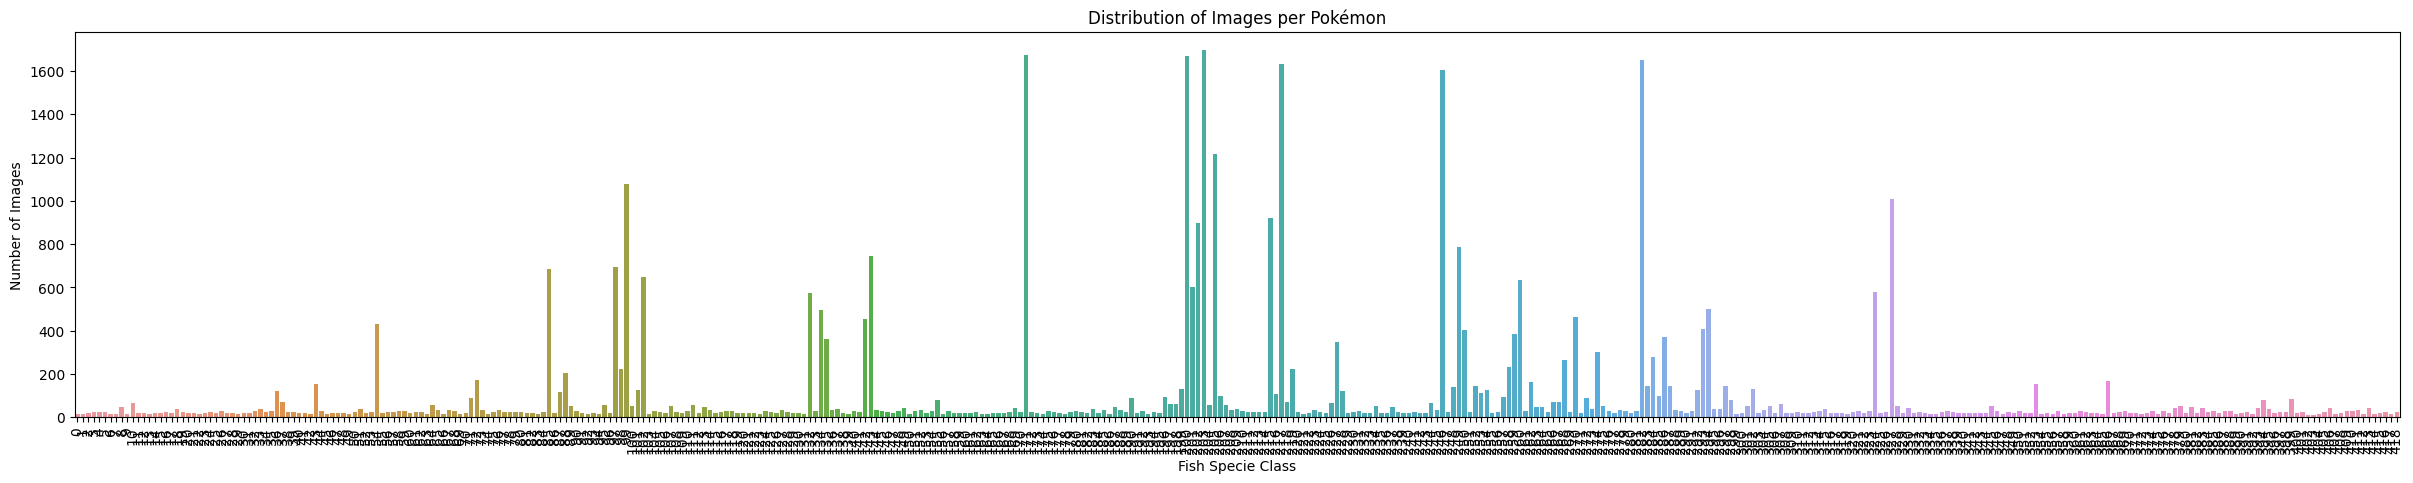



Statistics of the training data:

Total number of fish species in the dataset: 419
Minimum number of samples: 9
Maximum number of samples: 1695
Mean number of samples: 95.33651551312649
Median number of samples: 24.0


In [14]:
class_counts = df_train['id'].value_counts()

# Creating a bar chart of the distribution of classes
plt.figure(figsize=(30, 5)) 
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(rotation=90) 
plt.xlabel('Fish Specie Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Pokémon')
plt.show()

# Statistics of the data
min_images = class_counts.min()
max_images = class_counts.max()
mean_images = class_counts.mean()
median_images = class_counts.median()

print("\n\nStatistics of the training data:\n")
print("Total number of fish species in the dataset:", len(class_counts))
print("Minimum number of samples:", min_images)
print("Maximum number of samples:", max_images)
print("Mean number of samples:", mean_images)
print("Median number of samples:", median_images)

### **Observation 2 - Grouping Classes by Number of Samples**: 

To better understand the distribution of samples across classes we broadly group classes based on a threshholad of samples. We observe that majority (~80%) of classes have less than 50 samples per class and only ~2% of classes have more than 1000 samples.

This observation is used to run experiments related to `Experiment 1: Hard-Augmentation`, where we create a new augmented dataset with 50 samples per class. (See Section on `Model Training & Development`)

In [15]:
# 2) Trying to categorise the fish species based on number of samples for each class

# Convert "class_counts" to a dictionary
class_counts_dict = class_counts.to_dict()

# Initialising a dictionary to see the count of classes for the below listed categories
class_count_categories = {
    'above_1000': 0,
    'between_500_and_100': 0,
    'between_100_and_500': 0,
    'between_50_and_100': 0,
    'between_25_and_50': 0,
    'less_than_25': 0
}

# Categorising the classes based on their counts
for count in class_counts_dict.values():
    if count > 1000:
        class_count_categories['above_1000'] += 1
    elif 500 < count <= 1000:
        class_count_categories['between_500_and_100'] += 1
    elif 100 < count <= 500:
        class_count_categories['between_100_and_500'] += 1
    elif 50 < count <= 100:
        class_count_categories['between_50_and_100'] += 1
    elif 25 < count <= 50:
        class_count_categories['between_25_and_50'] += 1
    else:
        class_count_categories['less_than_25'] += 1

# Printing the results
for category, count in class_count_categories.items():
    print(f"Number of classes with {category.replace('_', ' ')} samples: {count}")

Number of classes with above 1000 samples: 9
Number of classes with between 500 and 100 samples: 11
Number of classes with between 100 and 500 samples: 38
Number of classes with between 50 and 100 samples: 31
Number of classes with between 25 and 50 samples: 96
Number of classes with less than 25 samples: 234


### **Observation 3 - Analysing Images**: 

We select the first 10 images from our training dataset to analyze their dimensions and content. Each image is observed to have a different size. As a result during the pre-processing phase we pad the image to create a square image to create consistency in the training dataset (implemented and explained above).

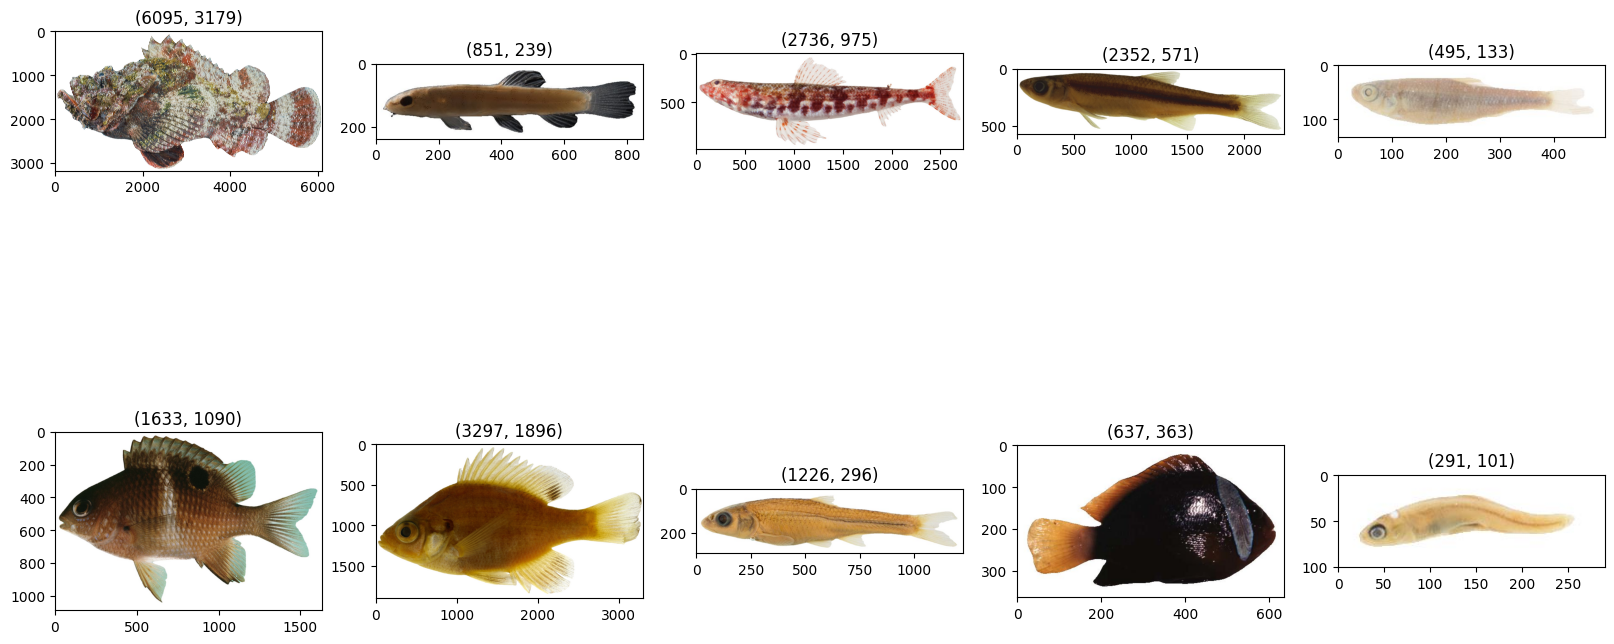

In [16]:
# 3) Analysing the images of 10 fishes

# Extracting the first ten elements from the train dataset
df_ten = df_train.head(n=10)
images = []

fig = plt.figure(figsize=(20,10))
for i in range(10):
    name = df_ten.iloc[i,1]
    img = Image.open(name)
    images.append(img)
    ax = plt.subplot(2,5,i+1)
    ax.set_title(img.size)
    ax.imshow(img)

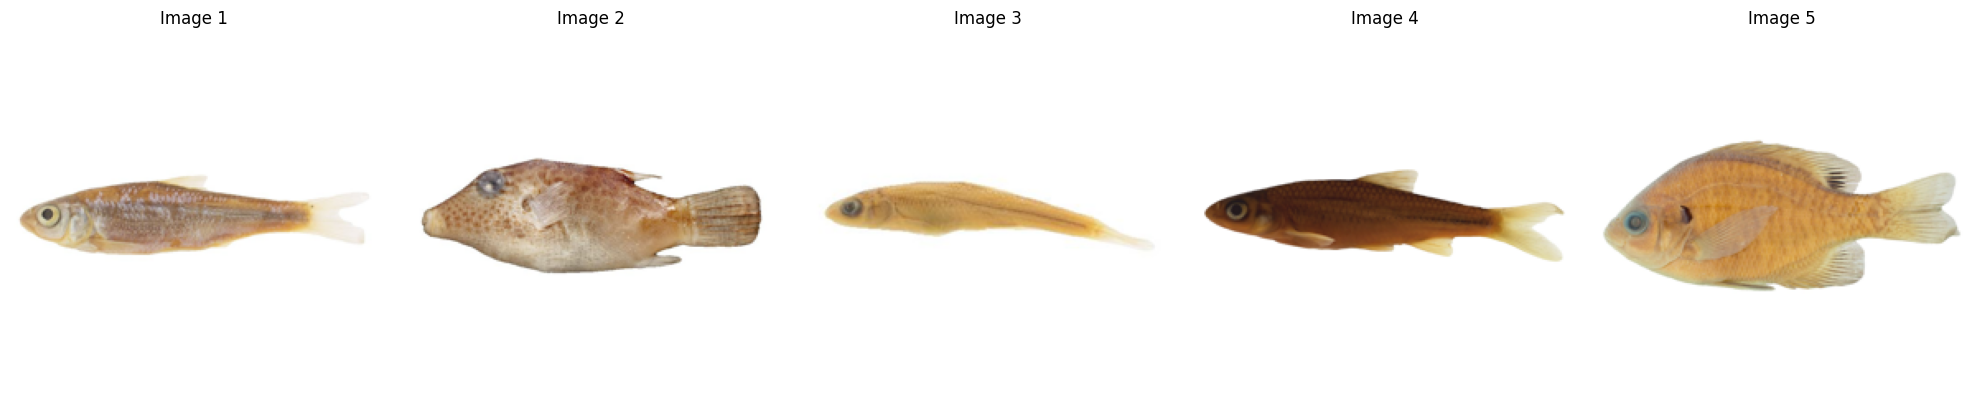

In [17]:
# Checking if the square padding has worked
def display_images(df, column_name, max_images=5):
    
    fig, axes = plt.subplots(1, max_images, figsize=(4 * max_images, 4))
    
    for idx, (row, ax) in enumerate(zip(df.head(max_images).iterrows(), axes)):
        image = np.load(row[1][column_name])  # Load the NumPy image
        ax.imshow(image, cmap='gray')  # Adjust colormap if needed
        ax.set_title(f"Image {idx + 1}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
display_images(df_submission, 'npy_path')

### **Observation 4 - PCA Analysis**: 

Here we try to determine if there is a relationship between color and fish ID. For this, we extracted the histogram features from the images and computed their PCA components and visualized the results to identify potential patterns. From the plot below we observed that there is no evident clustering of data points based on color intensities, indicating that the dataset consists of complex features. Hence, simpler models such as Random Forest cannot be used for performing the classification task, and we have too use advanced deep learning methods for the classification.

In [18]:
def extract_histogram_features(image):
    # Normalize the image to range [0, 1]
    normalized_image = (image / 255.0).astype('float32')

    hist_features = []
    for channel in range(3):  # R, G, B channels
        hist = cv2.calcHist([normalized_image], [channel], None, [256], [0, 1])  # Adjust range for normalization
        hist_features.extend(hist.flatten())
    return np.array(hist_features)

def process_and_plot(df, n_per_label=5, n_ids=20):
    """
    Extracts histogram features from images, performs PCA, and plots the PCA results.
    Selects n_per_label images per label.
    """
    # Randomly select n_ids unique IDs
    unique_ids = df['id'].unique()  # Get unique IDs
    selected_ids = np.random.choice(unique_ids, size=n_ids, replace=False)  # Randomly sample n_ids
    
    # Sample n_per_label images per selected ID
    sampled_df = df[df['id'].isin(selected_ids)]  # Filter rows for selected IDs
    sampled_df = sampled_df.groupby('id').apply(lambda x: x.sample(n=min(n_per_label, len(x))))
    
    # Reset index
    sampled_df = sampled_df.reset_index(drop=True)
    
    # Extract histogram features
    features = []
    labels = []
    for _, row in sampled_df.iterrows():
        image = Image.open(row['path'])
        image = np.array(image)
        label = row['id']
        hist_features = extract_histogram_features(image)
        features.append(hist_features)
        labels.append(label)
    
    # Perform PCA
    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features)
    
    # Plot PCA results
    plt.figure(figsize=(10, 7))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(features_pca[indices, 0], features_pca[indices, 1], label=label, alpha=0.7)
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.title("PCA of Histogram Features")
    plt.show()

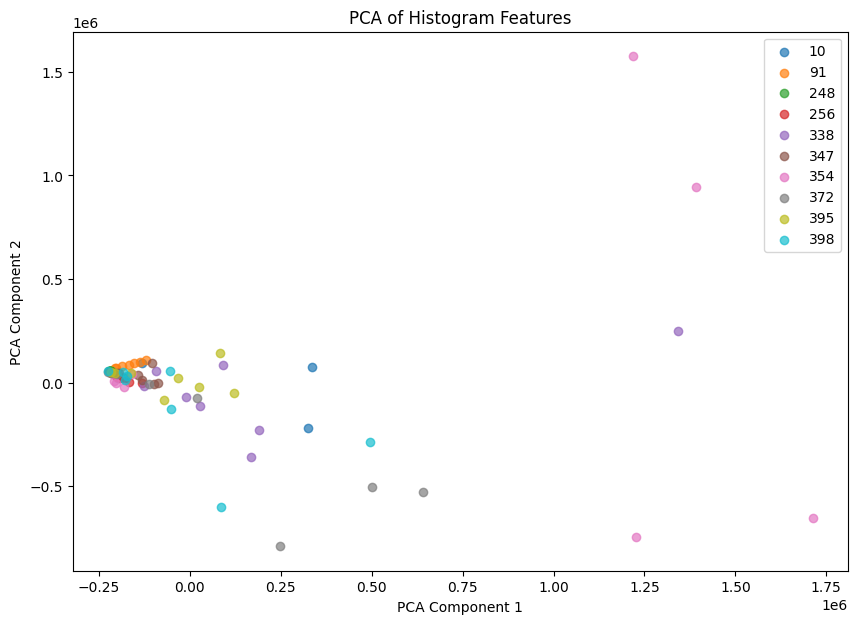

In [19]:
from sklearn.cluster import KMeans
# Plotting 10 ids per id 8 images.
process_and_plot(df_train, n_per_label=8, n_ids=10)

# Section 2: Data Pre-Processing

Given the significant imbalance in the training dataset (as seen in `Observation 2 & 3`), we decided to conduct various experiments to explore different approaches for addressing this issue and identifying the best solution. We focussed on the following 3 approaches:

* Approach 1: Hard data augmentation
* Approach 2: Re-weighting techniques
* Approach 3: Random data selection

This notebook captures the code related to the third method `Random data selection` as it gave us the best reuslts (as seen in Section 3 & 4). 

For some consistency across the above approaches tested, we ensured that the training images were suqare padded and the same data transformations were implemented including square padding,random rotation, random jitter, random horizontal flip, random verticle flip and normalization.


Below is a detailed explaination on the two approaches that are not captured in this notebook. It outlines why these approaches were selected and how they were implemented:

**1) HARD DATA AUGMENTATION:** 

We noted that 20% of the classes account for 80% of the images, while most labels are represented by only a few images. To address this imbalance, we wanted to run experiments where the model trains on a dataset with an equal number of images for all classes. 
    
To achieve this, we applied oversampling and undersampling techniques to create a balanced dataset with 50 samples per class. This decision was guided by `Observation 3` where we noted that 80% of classes have fewer than 50 samples. For classes with more than 50 images, we randomly selected 50 images. For minority classes with fewer than 50 images, we used data augmentation to generate the required number of samples. 
    
For augmentation, we used the transformations (including suqare padding) mentioned earlier, ensuring that each transformation had an equal probability of being applied. As a result, we generated a new training dataset consisting of 20,950 images. This new dataset ensures both computational efficiency (as its is smaller than the orignal dataset) and balanced representation across all classes (which is not affected by extensive data augmentation). For training purposes, we split the dataset into 90% for training and 10% for validation.

**2) RE-WEIGHTING:** 

Due to the significant class imbalance within our dataset, a model trained on this data tends to prioritize learning features from the majority classes (which represent only ~20% classes in the dataset), leading to overfitting for these classes. Hence, the model struggles to generalize and effectively learn features for the minority classes.

Our exploratory analysis revealed that approximately 80% of the classes have fewer than 50 samples per class (`Observation 3`). To address this imbalance, we decided to explore re-weighting strategies to help the model learn features from minority classes. We did this by using:

* **Weighted sampler:** We used Pytorch’s WeightedRandomSampler class with replacement = True, to increase the probability of sampling minority classes within a training set batch. Replacement = True enabled each sample to potentially be selected multiple times, with data augmentations  added to generate diverse versions of the same sample. To achieve this, we assigned weights to each sample in the training dataset, proportional to the inverse of its class frequency. These weights were then passed to the sampler, which was subsequently integrated into the data loader as a parameter.

* **Weighted loss function:** In addition to the weighted sampler, we implemented a weighted loss function to penalize misclassifications of minority classes, subsequently encouraging the model to focus on learning features for minority classes. The class weights were calculated as the inverse of each class’s frequency and normalized by the total number of classes (419). These weights were used to create a tensor, which was then provided as the weight parameter to our optimizer.

For training purposes the dataset was split into 90% training and 10% validation. To ensure minority classes are represented in the validation set, a stratified splitting strategy was used instead of random splitting. This was done by using the “stratify” parameter within scikit-learn’s train_test_split function. Additionally, the above mentioned data transformations were implemented on the training set images.

**3) RANDOM DATA AUGMENTATION**

Within this approach we are randomly selecting a subset of the training dataset at every epoch. The assumption is that we can reduce overfitting, while allowing the model to still train on the entire original dataset.

The strategy is implemented using two main steps:
* **Pre-processing:** Where we pre-process the data by applying some basic transformations to all images(mentioned above). However, pre-prcoessing is implmented with a higher probality of random processing for classes with few images.
  
* **Data selection strategy:** Here we have designed a data selection startegy for each epoch. For our case, we selected 3 image per class plus 2000 random images for training and 3 image per class plus 400 random images for validation.

For training purposes the dataset was split into 90% training and 10% validation using a stratified splitting methodology (explained above).

### Pre-processing data

In [20]:
class RandomRotate20:
    def __call__(self, img):
        # Randomly choose to apply rotation for 50% of the images
        if random.random() < 0.2:  # 50% chance
            return transforms.functional.rotate(img, random.uniform(-45, 45)) 
        return img 
    
class RandomJitter30:
    def __call__(self, img):
        if random.random() < 0.3:
            return transforms.ColorJitter(brightness=0.2, 
                                          contrast=0.2, 
                                          saturation=0.2,
                                          hue=0.02)(img)
        return img

# Basic Transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    RandomRotate20(),
    RandomJitter30(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# More Transformation where we have very low Images
preprocess_necessary = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),   # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),     # Randomly flip the image vertically
    transforms.RandomRotation(45),       # Randomly rotate the image by 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),  # Randomly change color
    transforms.ToTensor(),               # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_preprocess = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])

### Data loader

In [21]:
# Step 1: Define a custom dataset
class ImageDataset(Dataset):
    def __init__(self, image_files, 
                 labels=None, transform=None,
                 transform2=None, train_type=True):
#         self.image_dir = image_dir
        self.transform = transform
        self.transform2 = transform2
        self.image_files = image_files
        self.train_type = train_type
        if train_type==True:
            self.labels = labels

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        if 'aug:' in img_name[:4]:
            is_aug_needed = True
            img_name = img_name[4:]
        else:
            is_aug_needed = False
            
        image = load_numpy(img_name)  # Ensure image is in RGB mode
        image = Image.fromarray(image)

        if self.transform:
            if is_aug_needed:
                image = self.transform2(image)
            else:
                image = self.transform(image)

        if self.train_type==True:
            return image, self.labels[idx]
        else:
            return image

def create_dataloader(image_files, labels, _type=None):
    dataset = ImageDataset(image_files=image_files,
                           labels=labels, 
                           transform=preprocess,
                           transform2=preprocess_necessary)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    return dataloader

In [22]:
# test data loader is made from submission file
image_files = df_submission['npy_path'].tolist()
dataset = ImageDataset(image_files=image_files, 
                       transform=test_preprocess,
                       train_type=False)
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

### Data spliting strategy

In [23]:
def split_dataset(data, val_size=0.1):
    data_train, data_val = train_test_split(data, 
                                            test_size=val_size, 
                                            stratify=data['id'], 
                                            random_state=42)
    return data_train, data_val

def data_splitting_stratagy(data, target_per_label, random_sample=1000):
    # Group images by label
    label_to_images = defaultdict(list)
    for _, row in data.iterrows():
        label = row['id']
        image_path = row['npy_path']
        label_to_images[label].append(image_path)

    selected_images = []
    selected_labels = []

    for label, images in label_to_images.items():
        if len(images) >= target_per_label:
            # Randomly select `target_per_label` unique images
            selected = random.sample(images, target_per_label)
        else:
            # Use all available images and augment to reach `target_per_label`
            selected = images.copy()  # Start with available images
            num_needed = target_per_label - len(selected)

            # Augment until we reach the required count
            while num_needed > 0:
                img_path = random.choice(images)
                if num_needed <= 0:
                    break

                # Create augmented images
                augmented_image = 'aug:' + img_path  # Replace with actual augmentation logi
                selected.append(augmented_image)  # Add augmented image
                num_needed -= 1

        # Add selected images to the final list
        selected_images.extend(selected)
        selected_labels.extend([label] * len(selected))

    before_shape = data.shape[0]
    data = data[~data['npy_path'].isin(selected_images)]
    after_shape = data.shape[0]   
    # print(f'data shape difference: {after_shape-before_shape}')
    
    data = data.sample(n=random_sample, random_state=42)
    selected_images.extend(data['npy_path'].tolist())
    selected_labels.extend(data['id'].tolist())
    
    return selected_images, selected_labels

### Displaying few processed images

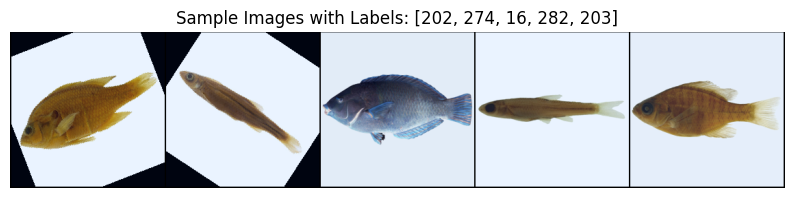

In [24]:
def show_images_from_dataloader(dataloader, num_images=5):
    # Get a batch of images and labels
    images, labels = next(iter(dataloader))  # Get the first batch
    images = images[:num_images]  # Select only the number of images you want to display
    labels = labels[:num_images]  # Corresponding labels or IDs
    
    # Create a grid of images (make_grid is from torchvision)
    grid_img = torchvision.utils.make_grid(images, nrow=num_images, normalize=True)
    
    # Display the images using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Permute to change the shape for plotting
    plt.title(f"Sample Images with Labels: {labels.tolist()}")
    plt.axis('off')  # Turn off axes
    plt.show()

def main_show_images():
    images, labels = data_splitting_stratagy(df_train, 3, 
                                             random_sample=2000)
    dataloader = create_dataloader(images, labels)
    show_images_from_dataloader(dataloader)

main_show_images()

# Section 3: Model Training & Development

In this section we describe the experiments conducted and results obtained for each of the approaches detailed in Section 2. The following notebook captures code from the best experiment conducted using the `Random Data Augmentation` approach. For consistency and comparison purposes, the experiments were run on Resnet-18.

**1) HARD DATA AUGMENTATION:**

We initialized the model with a pre-trained ResNet and fine-tuned it using our dataset. Cross-entropy was used as the loss function, and the Adam optimizer was applied with varying learning rates. To reduce overfitting, we implemented dropout regularization. The model was trained for a maximum of 100 epochs, employing an early stopping strategy with a patience of 10 epochs. Finally, we got the results shown in the Table below. All three experiments were noted to converge around 40 epochs. However, as shown by the final results, the validation accuracies were less than 70%, and did not perform as well as we expected. 

**2) RE-WEIGHTING:**

We conducted a series of experiments to assess model performance using the re-weighting method. These experiments explored the effects of different optimizers, regularization strategies, momentum, and the use of a warm-up period. All experiments were run for a maximum of 100 epochs, with early stopping implemented to halt training if the validation loss did not improve for 5 consecutive epochs. The parameters and corresponding results of the three key experiments are summarized in the Table below.

The Table highlights that both training and validation accuracies are low, with a significant gap between the two, particularly in the first two experiments. To better understand these results, we examined the most frequently misclassified classes using the confusion matrix.
Here we observed that the re-weighting strategy enabled the model to better classify samples from minority classes but at the expense of the majority classes. For example, class ‘203,’ which has 1,695 samples in the training dataset, was misclassified as class ‘210’ (which has only 27 samples.) for 78 instances. In contrast, class ‘418’ which has only 22 samples in the training dataset, was misclassified as class ‘341’ in just one instance. This suggested that the re-weighting strategy disproportionately emphasized the minority classes, making it harder for the model to learn the features of the majority classes.

To address this issue, we introduced a warm-up period, where the model was trained on the original dataset for the first five epochs before applying the re-weighting strategy. While this adjustment led to marginal improvements (see Experiment 2.2 results in the Table), it did not fully resolve the problem. We also decided to explore the strategy with the Adam optimizer without regularization and observed improved results. However, the issue of majority classes being misclassified as minority ones persisted.

Based on these observations, we decided to discontinue experiments with this strategy and shifted our focus to hard data augmentation and more innovative methods, which were yielding better outcomes at the time.

**3) RANDOM DATA AUGMENTATION:**

Within this approach we experimented with various architectures, including ResNet18, EfficientNetB2, and Vision Transformers. To enhance training efficiency and generalization, we utilized advanced learning rate strategies such as the OneCycle Learning Scheduler and CosineAnnealingWarmRestarts, achieving notable performance improvements. 

Additionally, we implemented Early Stopping to monitor validation loss during training. We set a patience of 50 epochs, allowing the training process to continue only if there was consistent improvement in validation loss. If no improvement was observed within this period, the training was automatically terminated, preventing overfitting and saving computational resources. The results from the experiments are as found in the Table below.

Initally we had also tried using Focal Loss, specifcally when we had not balanced our dataset. However, this was discarded after using data strategy (i.e manual balancing explained in `Section 2`) as it did not affect our results.

**Note:** We further detail our observations from the best model within the below sub-sections.

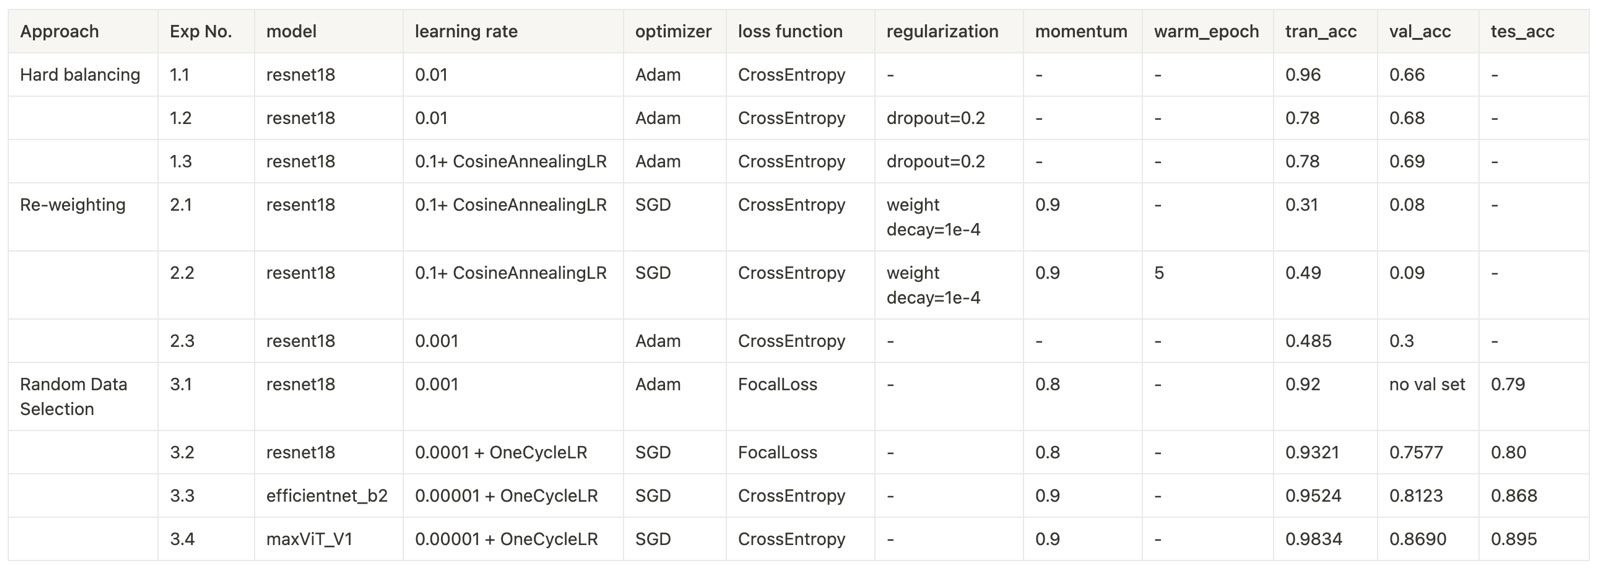
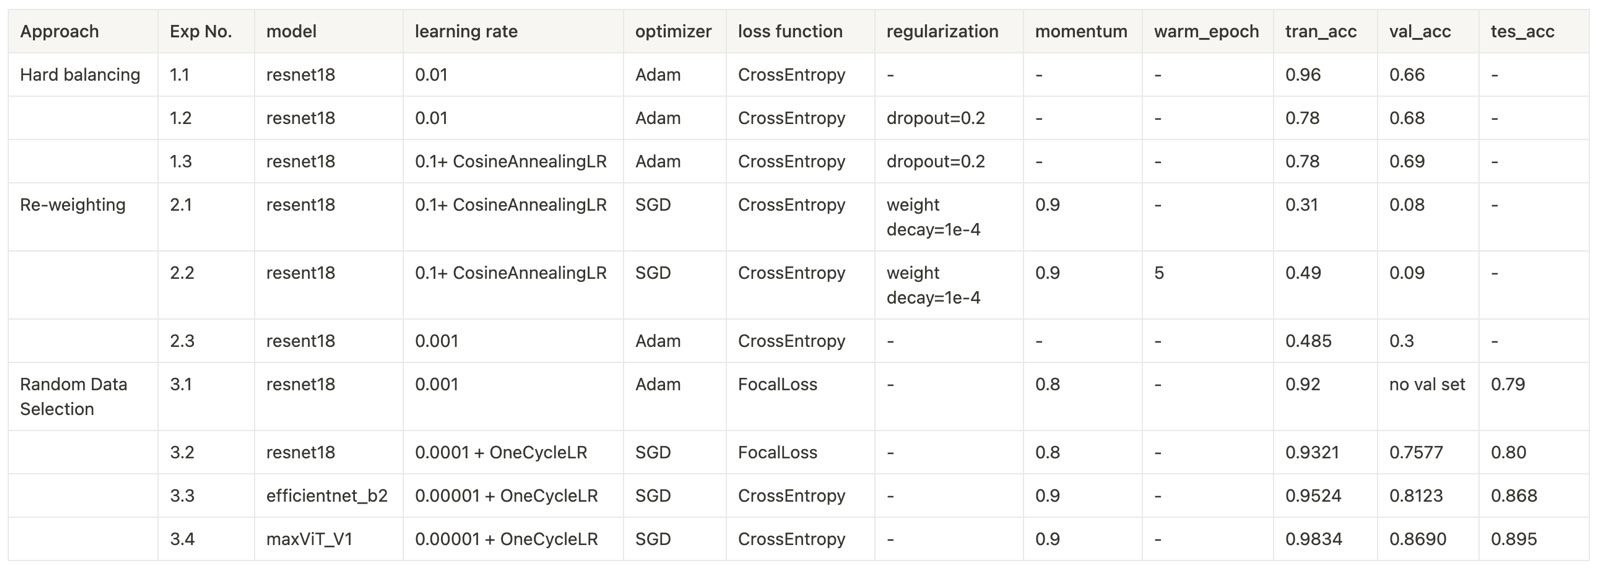

### Model Training & Validation

In [25]:
def run(epochs=300):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Total number of classes
    num_classes = 419

    # Load transformer model
    model = models.maxvit.maxvit_t(weights='IMAGENET1K_V1').to(device)
    model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, 419, bias=False)
    model = model.to(device)

    # Un-Freeze all layers 
    for param in model.parameters():
        param.requires_grad = True

    # Using two GPU
    if torch.cuda.device_count() > 1:
        print("Using", torch.cuda.device_count(), "GPUs")
        model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)
        
    # Set model to training mode
    model.train()
    
    # Loss function.
    criterion = torch.nn.CrossEntropyLoss()  
    
    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), 
                                        momentum=0.95,
                                        lr=0.01)
    
    # Dataset creation, As we have already splited the dataset so, we are loading saved data
    # data_train, data_val = split_dataset(df_train, val_size=0.1)
    data_train = pd.read_csv('/kaggle/input/competition-v2/data_train.csv')
    data_val = pd.read_csv('/kaggle/input/competition-v2/data_val.csv')

    # Data Statragy and data loader
    images, labels = data_splitting_stratagy(data_train, 3, 
                                             random_sample=2000)
    dataloader = create_dataloader(images, labels)

    images_val, labels_val = data_splitting_stratagy(data_val, 3, 
                                                     random_sample=400)
    dataloader_val = create_dataloader(images_val, labels_val, _type='val')

    # hyper-perameters
    epochs = epochs
    early_stop_counter = 0
    patience = 20
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                    optimizer, 
                     T_0=10, 
                     T_mult=2,
                     eta_min=1e-6)

    # Other parameters for storing the progress
    best_epoch_loss = float('inf')
    checkpoint_index = 0
    train_history = []
    val_history   = []
    
    for epoch in range(epochs):
        if epoch>0:
            images, labels = data_splitting_stratagy(data_train, 3, 
                                                     random_sample=2000)
            dataloader = create_dataloader(images, labels)

            images_val, labels_val = data_splitting_stratagy(data_val, 3, 
                                                             random_sample=400)
            dataloader_val = create_dataloader(images_val, labels_val, _type='val')
            
        running_loss = 0.0
        running_corrects = 0
        total = 0

        for i, (images, _labels) in enumerate(tqdm(dataloader)):
            optimizer.zero_grad()
            images = images.to(device)
            _labels = _labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, _labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(torch.max(outputs, 1)[1] == _labels.data)
            total += _labels.size(0)

        # Calculate average loss and accuracy over the epoch
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total

        train_history.append([epoch_acc, epoch_loss])
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # evaluation
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for val_images, val_labels in tqdm(dataloader_val):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # Forward pass for validation
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)

                # Accumulate loss and accuracy
                val_running_loss += val_loss.item() * val_images.size(0)
                val_running_corrects += torch.sum(torch.max(val_outputs, 1)[1] == val_labels.data)
                val_total += val_labels.size(0)

        # Calculate average validation loss and accuracy
        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = val_running_corrects.double() / val_total

        val_history.append([val_epoch_acc, val_epoch_loss])

        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_acc:.4f}')

        if val_epoch_loss < best_epoch_loss:
            best_epoch_loss = val_epoch_loss
            early_stop_counter = 0
            # Save the checkpoint
            torch.save(model, f'best_model_checkpoint.pt')
            print("Saved best model!")
        else:
            early_stop_counter += 1
            if epoch%10==0:
                torch.save(model, f'model_checkpoint_ep_{epoch}.pt')
        
        # Stop training if patience is exceeded
        if early_stop_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

        # Step the scheduler to adjust the learning rate
        scheduler.step()
        
    print('Training complete.')
    return train_history, val_history

In [26]:
# Originally, we have run for the 300 epoachs but converges way before
# Now we are only running for 3 epoachs
train_history, val_history = run(epochs=3)

Using device: cuda


Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /root/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:05<00:00, 24.5MB/s]


Using 2 GPUs


100%|██████████| 102/102 [01:17<00:00,  1.32it/s]


Epoch 1/3, Loss: 5.1047, Accuracy: 0.0737


100%|██████████| 52/52 [00:21<00:00,  2.39it/s]


Validation Loss: 5.2031, Validation Accuracy: 0.0646
Saved best model!


100%|██████████| 102/102 [01:14<00:00,  1.37it/s]


Epoch 2/3, Loss: 4.1724, Accuracy: 0.1609


100%|██████████| 52/52 [00:18<00:00,  2.86it/s]


Validation Loss: 4.3034, Validation Accuracy: 0.1503
Saved best model!


100%|██████████| 102/102 [01:12<00:00,  1.42it/s]


Epoch 3/3, Loss: 3.4165, Accuracy: 0.2561


100%|██████████| 52/52 [00:15<00:00,  3.29it/s]


Validation Loss: 3.6944, Validation Accuracy: 0.2167
Saved best model!
Training complete.


### Ploting the progess: loss and accuracy
As we monitored the training and validation loss and accuracy over time, we observed that the model improved rapidly during the initial stages of training. However, the rate of improvement gradually slowed down as training progressed.

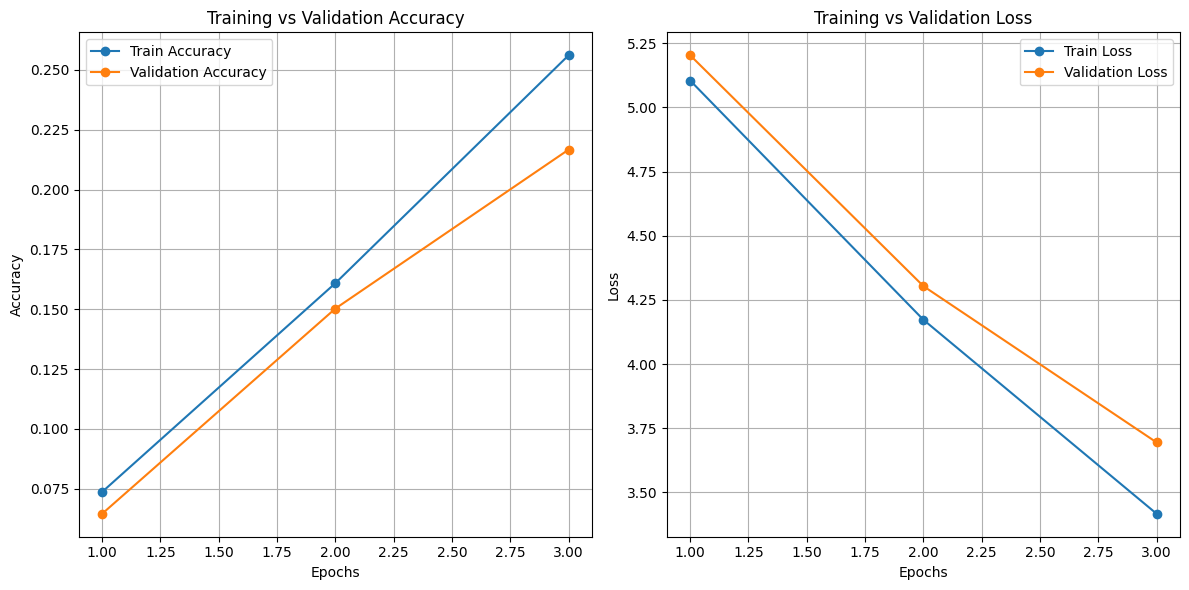

In [27]:
# Extract training and validation accuracy and loss
train_accuracy = [val[0].cpu().numpy() for val in train_history]
train_loss = [val[1] for val in train_history]
val_accuracy = [val[0].cpu().numpy() for val in val_history]
val_loss = [val[1] for val in val_history]

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', marker='o')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

### Results evalution

To further explore the results on the validation set, we plotted 2 main charts:

1) Total Errors vs Number of Samples per Class
2) Distribution of Error Rate across classes

Chart 1 illustrates the relationship between the number of errors and the total samples per class in the validation dataset. We observe that classes with sufficient samples tend to perform well, while those with fewer samples exhibit higher error rates. However, due to the small validation set (10% of the total dataset), the limited sample size for certain classes makes it difficult to draw reliable conclusions about the model's performance on low-sample cases. The small sample size limits the statistical significance of these observations.

Chart 2 shows the distribution of error rates per class. It clearly demonstrates that our model performs well for the majority of classes, with low error rates observed across most of the distribution.

In [28]:
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


def analyze_model_errors(data_loader, model_path, num_classes=419):
    """
    Analyzes model errors for a multi-class classification problem.
    
    Parameters:
        data_loader (DataLoader): DataLoader for the dataset to analyze (should yield batches of data and labels).
        model_path (str): Path to the saved model file.
        num_classes (int): Number of classes (default: 419).

    Returns:
        None (displays plots and error statistics).
    """
    # Load the model
    model = torch.load(model_path)
    model.eval()
    
    # Initialize counters
    total_samples_per_class = Counter()
    error_counts_per_class = Counter()
    
    all_labels = []
    all_preds = []
    
    correct_predictions = 0
    total_samples = 0
    
    # Run predictions and track errors
    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            # Move data to the correct device if needed
            images, labels = images.to('cuda'), labels.to('cuda')
            
            # Get predictions
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Track labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Count correct predictions and errors
            correct_predictions += (preds == labels).sum().item()
            total_samples += labels.size(0)
            
            # Count samples per class and errors
            for label, pred in zip(labels, preds):
                total_samples_per_class[int(label)] += 1
                if label != pred:  # Count errors if prediction is incorrect
                    error_counts_per_class[int(label)] += 1

    # Calculate the confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    
    # Convert counters to arrays for easy plotting
    total_samples_array = np.array([total_samples_per_class[i] for i in range(num_classes)])
    error_counts_array = np.array([error_counts_per_class[i] for i in range(num_classes)])

    # Error rates per class
    error_rates = np.divide(error_counts_array, total_samples_array, out=np.zeros_like(error_counts_array, dtype=float), where=total_samples_array != 0)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {overall_accuracy:.4f}")

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion matrix
    print("\nConfusion Matrix:")
    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_mat, annot=False, fmt='d', cmap='Blues', cbar=True)
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot errors vs. number of samples per class
    plt.figure(figsize=(12, 6))
    plt.scatter(total_samples_array, error_rates, alpha=0.7, color='orange', label="Total Errors per Class")
    plt.xlabel("Number of Samples per Class")
    plt.ylabel("Total Errors per Class")
    plt.title("Total Errors vs. Number of Samples per Class")
    plt.legend()
    plt.show()

    # Plot error rate distribution
    plt.figure(figsize=(12, 6))
    plt.hist(error_rates, bins=50, color='skyblue', edgecolor='black')
    plt.xlabel("Error Rate per Class")
    plt.ylabel("Number of Classes")
    plt.title("Distribution of Error Rates across Classes")
    plt.show()

    # Display error rate summary
    avg_error_rate = np.mean(error_rates)
    median_error_rate = np.median(error_rates)
    print(f"Average Error Rate: {avg_error_rate:.4f}")
    print(f"Median Error Rate: {median_error_rate:.4f}")
    
    # Optional: Analyze the top 10 classes with the most errors
    top_error_classes = error_counts_array.argsort()[-10:][::-1]
    print("Top 10 Classes with Most Errors:")
    for i in top_error_classes:
        print(f"Class {i}: Total Errors = {error_counts_array[i]}, Samples = {total_samples_array[i]}, Error Rate = {error_rates[i]:.4f}")

100%|██████████| 125/125 [00:40<00:00,  3.11it/s]


Overall Accuracy: 0.3840
Precision: 0.3324
Recall: 0.3840
F1-Score: 0.3205

Confusion Matrix:


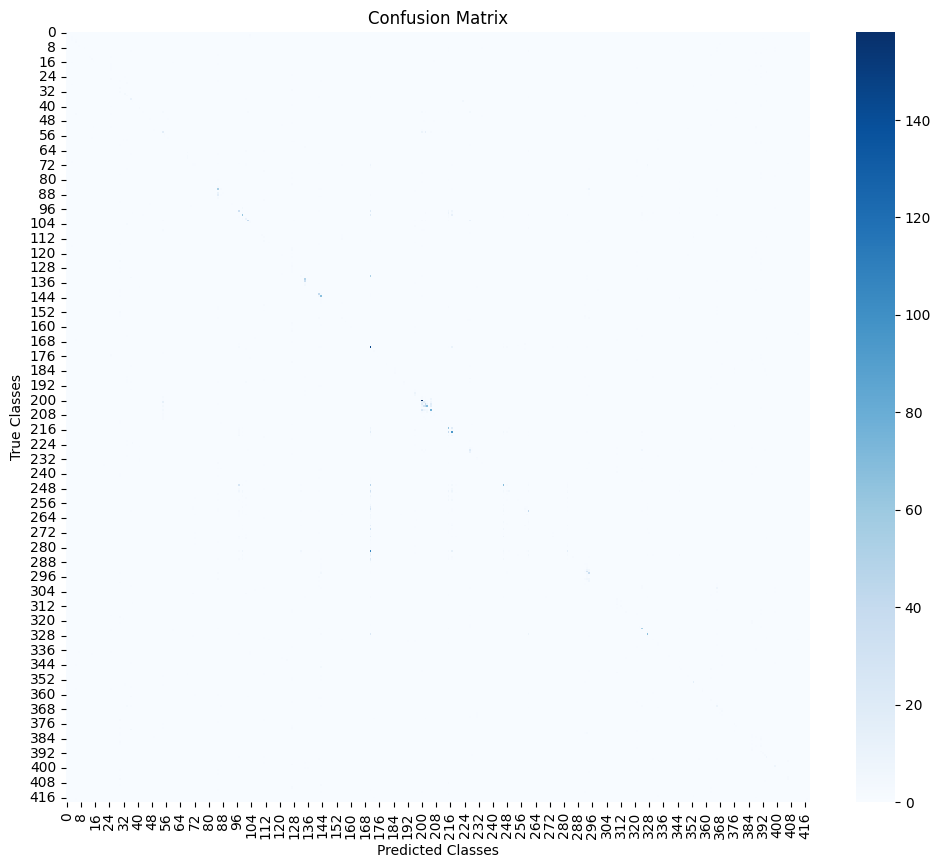

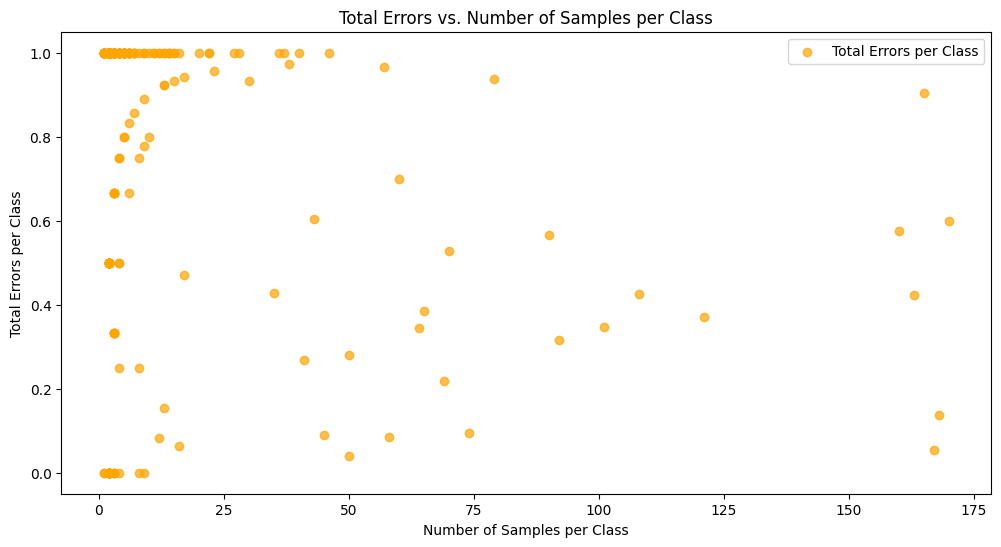

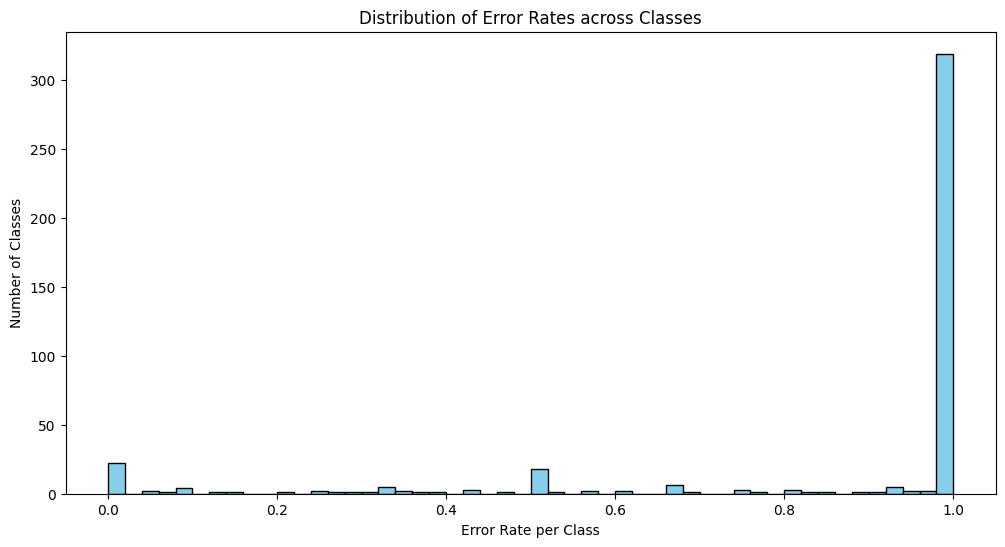

Average Error Rate: 0.8597
Median Error Rate: 1.0000
Top 10 Classes with Most Errors:
Class 282: Total Errors = 149, Samples = 165, Error Rate = 0.9030
Class 203: Total Errors = 102, Samples = 170, Error Rate = 0.6000
Class 246: Total Errors = 92, Samples = 160, Error Rate = 0.5750
Class 249: Total Errors = 74, Samples = 79, Error Rate = 0.9367
Class 217: Total Errors = 69, Samples = 163, Error Rate = 0.4233
Class 132: Total Errors = 55, Samples = 57, Error Rate = 0.9649
Class 202: Total Errors = 51, Samples = 90, Error Rate = 0.5667
Class 99: Total Errors = 46, Samples = 108, Error Rate = 0.4259
Class 270: Total Errors = 46, Samples = 46, Error Rate = 1.0000
Class 205: Total Errors = 45, Samples = 121, Error Rate = 0.3719


In [29]:
df_val = pd.read_csv('/kaggle/input/competition-v2/data_val.csv')
val_dataloader = create_dataloader(image_files=df_val['npy_path'], labels=df_val['id'])
analyze_model_errors(val_dataloader, '/kaggle/working/best_model_checkpoint.pt')

### Evaluating on test dataset

In [30]:
# Function to predict labels for the entire test set
def predict_on_test(model, test_loader, device):
    
    # Set the model to evaluation mode
    model.eval()
    
    # List to store all predictions and true labels
    all_predictions = []
    all_true_labels = []
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        for i, images in enumerate(tqdm(test_loader)):
            # Move images and labels to the appropriate device (CPU/GPU)
            images = images.to(device)
            
            # Pass the images through the model
            outputs = model(images)
            
            # Get the predicted labels by finding the index with the highest score
            _, predicted_labels = torch.max(outputs, 1)
            
            # Store the predictions and true labels
            all_predictions.extend(predicted_labels.cpu().numpy())  
            
    return all_predictions

# best_model = models.resnet18(pretrained=False).to(device)
# best_model.fc = torch.nn.Linear(best_model.fc.in_features, num_classes)
device='cuda'
best_model = torch.load('/kaggle/working/best_model_checkpoint.pt')
best_model = best_model.to(device)
# Load the saved state dict
# best_model.load_state_dict(torch.load('/kaggle/working/best_model_checkpoint.pt'))

# best_model = best_model.to(device)

predictions = predict_on_test(best_model, test_dataloader, device=device)

100%|██████████| 246/246 [01:26<00:00,  2.83it/s]


In [31]:
df_submission['id'] = predictions
df_final = df_submission.drop(columns=['path', 'npy_path'])
df_final.head()

,filename,id
0,60780_lat_FMNH_FZ_ab.jpg,215
1,"BMNH 1958.6.6.1, Tetrodon solandri HOLOTYPE-S.jpg",363
2,69092_lat_FMNH_FZ_dn.jpg,171
3,INHS_FISH_10458.jpg,282
4,JFBM-FISH-0041943.jpg,201


### Creating submissions file

In [32]:
df_final.to_csv('submission.csv', index=False)

# Section 4: Conclusion and Future Work

During this project, we focused on assisting the model in learning meaningful features by implementing various methods to balance the dataset, and carefully analyzing the results to drive improvements. We started with heavy augmentation and manually balanced the dataset by creating augmented images, which initially performed well. We then explored reweighting to emphasize labels with fewer samples, but it did not meet expectations. Finally, we applied random data selection, selecting 'n' samples from each class, which delivered the best results and significantly boosted performance. As a result, we successfully achieved an accuracy of 89.6% on the leaderboard.

In terms of future work:

* Train on the entire validation dataset once before submitting the final predictions to expose the model to all available data.
* Experiment with a different number of samples per class within the `Random data selection strategy`.
* Conduct further experiments with learning rates, momentum, and learning rate schedulers.
* Apply additional image augmentations to create more challenging samples, helping the model learn independent features better.
* Combine approaches such as reweighting and random data selection to evaluate their combined effect.
* Explore different types of models.
* Experiment with various regularization techniques for further improvements.
